# DTM (Figures 1, 2 and Tables 1, 2)

This is adapted (partially) from https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/dtm_example.ipynb


In [1]:
from gensim import corpora, utils
from gensim.models.wrappers.dtmmodel import DtmModel
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
import json
import re

from gensim.parsing.preprocessing import STOPWORDS

# script author (me) defined stop words
STOPWORDS_ = ['rt', '-', '', 'httpst', 'amp']

# load the tweets
documents = []
time_seq = []
weeknum = ''
with open('../data/c_twitter.json') as f_in:
    for i, l in enumerate(f_in):
        c_twt = json.loads(l)
        
        # remove punctuation and stopwords for this analysis
        words = re.sub('[\.,#?!]', '', c_twt['text'])
        words = words.split()
        words = [w for w in words if (w not in STOPWORDS and w not in STOPWORDS_)]
        words = [bytes(w, 'utf-8') for w in words]
        
        # c_twt: {'weeknum': str, 'c_text': str, 'tags': [str]}
        documents.append(words)
        
        if weeknum != c_twt['weeknum']:
            time_seq.append(i)
            weeknum = c_twt['weeknum']
            
time_seq = time_seq[1:]
time_seq.append(len(documents))

acc = 0
for i in range(1, len(time_seq)):
    acc = acc + time_seq[i-1]
    time_seq[i] = time_seq[i] - acc

print(time_seq)

[70188, 35805, 95850, 120178, 24229, 8858, 22689, 95447, 47808, 22841, 10388, 44524, 25175]


In [3]:
class DTMcorpus(corpora.textcorpus.TextCorpus):

    def get_texts(self):
        return self.input

    def __len__(self):
        return len(self.input)

corpus = DTMcorpus(documents)

In [4]:
dtm_binary_path = '/high_spd_work/sm_w2v/tools/dtm/dtm/dtm'
model = DtmModel(dtm_binary_path, corpus, time_seq, num_topics=10,
                 id2word=corpus.dictionary, initialize_lda=True, rng_seed=0)

In [5]:
model.save('../models/dtm_example.model')
# model = DtmModel.load('../models/doc2vec.model')

In [6]:
topics = model.show_topic(topicid=3, time=11, topn=20)
topics

[(0.073508371853503951, 'hiv'),
 (0.038385765205381818, 'charlie'),
 (0.029297517242700456, 'sheen'),
 (0.019213108226294316, 'people'),
 (0.017203876108692544, 'doctor'),
 (0.01367285564994372, 'cure'),
 (0.013437425312337799, 'aids'),
 (0.010667089925172714, 'claims'),
 (0.010405754625762218, 'gay'),
 (0.010392708586859142, 'cured'),
 (0.0097877928789976351, 'meds'),
 (0.0096417046815353829, 'wants'),
 (0.0073640739894170922, 'told'),
 (0.0073447791440759162, 'wear'),
 (0.0070819318285900244, 'says'),
 (0.0066707830972669146, 'news'),
 (0.0066700107092943295, "sheen's"),
 (0.0064687430203153561, '911well'),
 (0.0062745271774479142, 'blood'),
 (0.0059918149234362015, "he's")]

# Figure 1, 2 and Table 1, 2: Dynamic Topic Modeling

I'm proposing that in figures 1 and 2, we pick 2 topics from the Dynamic Topic Model, and describe the progression in time of these 2 topics with time series graphs, and tables 1 and 2 will be top 10 tables of these same topics over time


Topic ID's 8, 7 and 3 are all interesting

In [7]:
# This cell just gets the week nums (YYYY-WW)
def weeknums():
    # first  week is 2015-47
    week = 47
    year = 2015
    weeknums = []
    for i in range(len(model.time_slices)):
        weeknums.append(str(year) + '-' + str(week))
        week =+ 1

        if week > 53:
            year =+ 1
            week = 1
    return weeknums

weeknums = weeknums()

# Table 1: top 10 words associated with topic ID 3 over time

note how 'prep' is absent from top ten in the beginning, then increases over time

In [8]:
for t_index in range(len(model.time_slices)):
    print("--- time slice: ", t_index, "\n")
    print(pd.DataFrame(model.show_topic(topicid=3, time=t_index, topn=10), columns=['Probability', 'Word']))
    print()

--- time slice:  0 

   Probability      Word
0     0.097337   charlie
1     0.088663       hiv
2     0.073803     sheen
3     0.017848   sheen's
4     0.017397     jenny
5     0.016991  mccarthy
6     0.011918      told
7     0.011347  positive
8     0.011283     signs
9     0.010107  pornstar

--- time slice:  1 

   Probability        Word
0     0.094799         hiv
1     0.084704     charlie
2     0.065810       sheen
3     0.015870     sheen's
4     0.013351       signs
5     0.013335        told
6     0.012443       jenny
7     0.012088    mccarthy
8     0.010996   infection
9     0.010291  girlfriend

--- time slice:  2 

   Probability        Word
0     0.103756         hiv
1     0.068246     charlie
2     0.054638       sheen
3     0.015972       signs
4     0.014480   infection
5     0.013043     sheen's
6     0.012734        told
7     0.009552  girlfriend
8     0.008846    pornstar
9     0.008083    positive

--- time slice:  3 

   Probability        Word
0     0.111792   

# Figure 1: key terms associated with ID 3 over time

note how 'prep' is absent from top ten in the beginning, then increases over time

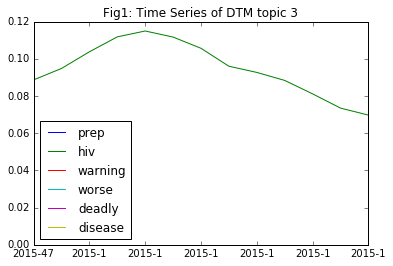

In [9]:
data = []
for t_index in range(len(model.time_slices)):
    words = model.show_topic(topicid=3, time=t_index, topn=1000)
        
    columns = ['prep', 'hiv', 'warning', 'worse', 'deadly', 'disease']
    row = []
    for col in columns:
        cell = [w[0] for w in words if w[1] == col]
        if not cell:
            cell = .000001
        else:
            cell = cell[0]
        row.append(cell)
    data.append(row)
    
df = pd.DataFrame(data, columns=columns, index=weeknums)
ax = df.plot(title='Fig1: Time Series of DTM topic 3')
fig = ax.get_figure()
fig.savefig('Fig1: Time Series of DTM topic 3.pdf', format='pdf')

# Table 2: top 10 words associated with topic ID 8 over time
Note how at time points 2 and 3 we get world AIDS day related words. At time points 7, 8 and 9 the antibiotic 'Zithromax' appears, then disappears. 'gay' also seems to come up during the later time points, which parallels the #egaylity in the Doc2Vec results. 'rt' is not entirely interesting, since it is the name of a news agency.

In [10]:
for t_index in range(len(model.time_slices)):
    print("--- time slice: ", t_index, "\n")
    print(pd.DataFrame(model.show_topic(topicid=8, time=t_index, topn=10), columns=['Probability', 'Word']))
    print()

--- time slice:  0 

   Probability          Word
0     0.060085          aids
1     0.054837           hiv
2     0.039928         world
3     0.037107           day
4     0.021748       hivaids
5     0.014857          life
6     0.010076  hiv-positive
7     0.009009         facts
8     0.007892        stigma
9     0.007873         today

--- time slice:  1 

   Probability          Word
0     0.064072          aids
1     0.051212           hiv
2     0.044701           day
3     0.042510         world
4     0.022030       hivaids
5     0.015275          life
6     0.010107  hiv-positive
7     0.009028         facts
8     0.008055         today
9     0.007168     awareness

--- time slice:  2 

   Probability          Word
0     0.064871          aids
1     0.050183           day
2     0.047472           hiv
3     0.042198         world
4     0.022127       hivaids
5     0.015368          life
6     0.009449  hiv-positive
7     0.008570         facts
8     0.007934         today
9     0

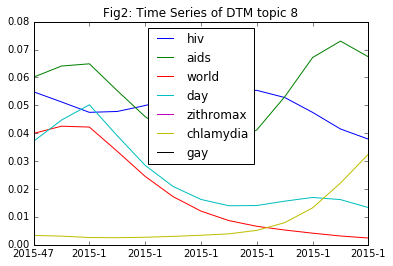

In [11]:
data = []
for t_index in range(len(model.time_slices)):
    words = model.show_topic(topicid=8, time=t_index, topn=1000)
        
    columns = ['hiv', 'aids', 'world', 'day', 'zithromax', 'chlamydia', 'gay']
    row = []
    for col in columns:
        cell = [w[0] for w in words if w[1] == col]
        if not cell:
            cell = .000001
        else:
            cell = cell[0]
        row.append(cell)
    data.append(row)


df = pd.DataFrame(data, columns=columns, index=weeknums)
ax = df.plot(title='Fig2: Time Series of DTM topic 8')
fig = ax.get_figure()
fig.savefig('Fig2: Time Series of DTM topic 8.pdf', format='pdf')